<a href="https://colab.research.google.com/github/blancavazquez/Analisis-datos-masivos-2024/blob/main/notebooks/4d_casoNetflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sistema de recomendación: caso Netflix

Objetivo: construir un sistema de recomendación de películas basado en los datos de Netflix.

Los pasos a seguir son:
* Análisis de datos
* Pre-procesamiento
* Construcción del sistema de recomendación
    - Usando filtrado colaborativo

[Créditos y fuente de datos](https://www.kaggle.com/laowingkin/netflix-movie-recommendation)

In [1]:
"""Carga de bibliotecas"""
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357282 sha256=6d05b636c076e087543779745e082ca4ccd472248e212c560eff32e8fdf690a4
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
"""Carga de la base de datos"""
#selección de ID y rating
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/combined_data_1.txt',
                 header = None, names = ['User_Id', 'Rating'], usecols = [0,1])
df['Rating'] = df['Rating'].astype(float)
print("Tamaño original:", df.shape)

Tamaño original: (24058263, 2)


In [4]:
df_raiting = df[:500000] #selección de sub-conjunto de registros
df_raiting.tail(10)

,User_Id,Rating
499990,2284938,3.0
499991,996626,4.0
499992,1778262,1.0
499993,1823668,2.0
499994,1129025,4.0
499995,1957556,4.0
499996,1492198,3.0
499997,1018901,3.0
499998,213704,4.0
499999,2143870,3.0


In [5]:
print('Tamaño de la base de datos: {}'.format(df_raiting.shape))

Tamaño de la base de datos: (500000, 2)


## Análisis de datos

In [6]:
print("Conteo de raitings")
p = df_raiting.groupby('Rating')['Rating'].agg(['count'])
print(p)

Conteo de raitings
         count
Rating        
1.0      25316
2.0      52325
3.0     147151
4.0     174248
5.0     100812


In [7]:
movie_count = df_raiting.isnull().sum()[1]#Se obtiene el total de películas
users_count = df_raiting['User_Id'].nunique() - movie_count#Se obtiene el total de usuarios
rating_count = df_raiting['User_Id'].count() - movie_count#Se obtiene el total de ratings

print("Total de películas:", movie_count, "total de usuarios:", users_count, "total de ratings:", rating_count)

Total de películas: 148 total de usuarios: 214992 total de ratings: 499852


<ipython-input-7-1070f575c654>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_count = df_raiting.isnull().sum()[1]#Se obtiene el total de películas


<ipython-input-8-f9806fa48143>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')


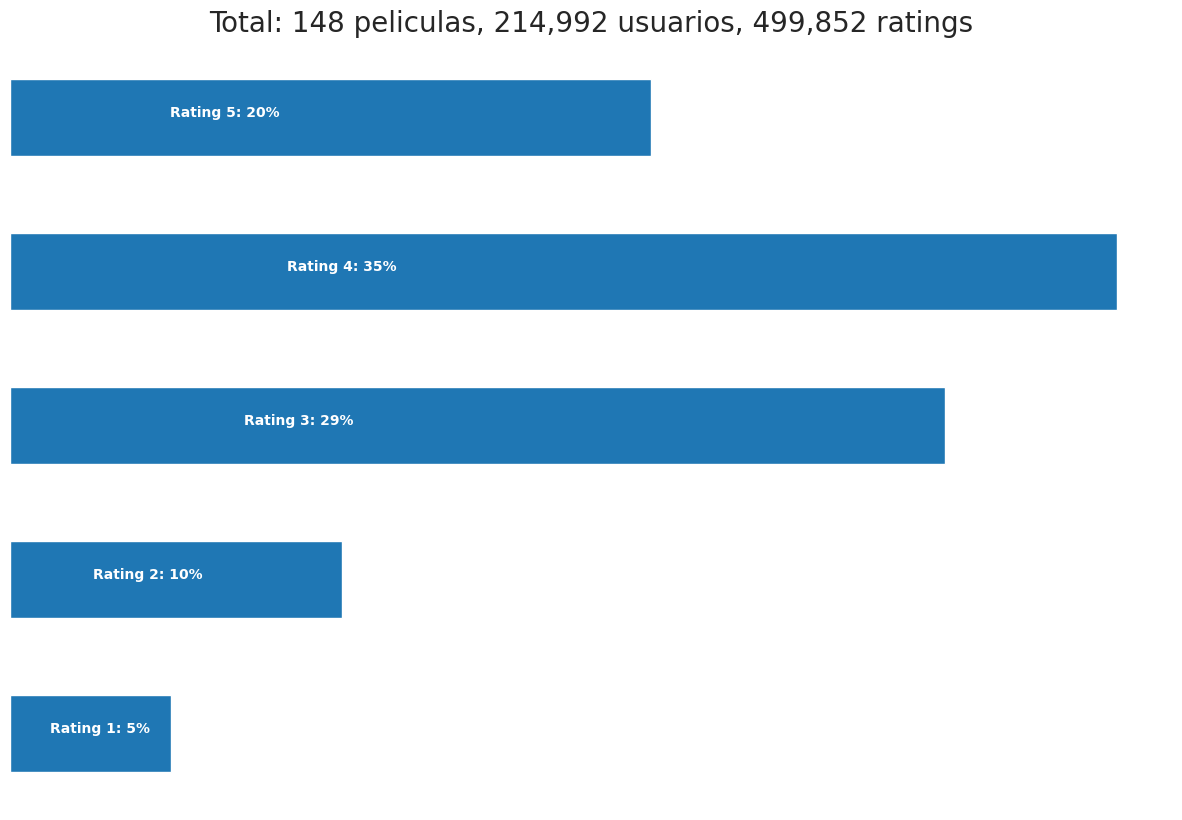

In [8]:
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total: {:,} peliculas, {:,} usuarios, {:,} ratings'.format(movie_count, users_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

Se observa que la mayoría de los ratings tiende a ser positiva (>3)

## Pre-procesamiento

In [9]:
"""Crear una matriz para el ID de la película (procesamiento más eficiente)"""
df_nan = pd.DataFrame(pd.isnull(df_raiting.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

print("Tamaño df_nan:", df_nan.shape)
df_nan.head(10)

Tamaño df_nan: (148, 2)


,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
5,3991,True
6,5011,True
7,5105,True
8,20016,True
9,20112,True


In [10]:
movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id) #Return a new array of given shape and type, filled with movie_id
    movie_np = np.append(movie_np, temp)
    movie_id += 1

In [11]:
movie_np

array([  1.,   1.,   1., ..., 147., 147., 147.])

In [12]:
# Se toma en cuenta el último registro y la longitud correspondiente
last_record = np.full((1,len(df_raiting) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record) #indices de las películas

print('Películas (numpy): {}'.format(movie_np))

Películas (numpy): [  1.   1.   1. ... 148. 148. 148.]


In [13]:
"""Visualizamos nuevamente"""
df_raiting = df_raiting[pd.notnull(df_raiting['Rating'])]

df_raiting['Movie_Id'] = movie_np.astype(int)
df_raiting['User_Id'] = df_raiting['User_Id'].astype(int)
df_raiting

<ipython-input-13-afd6057dc905>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raiting['Movie_Id'] = movie_np.astype(int)
<ipython-input-13-afd6057dc905>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raiting['User_Id'] = df_raiting['User_Id'].astype(int)


,User_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
499995,1957556,4.0,148
499996,1492198,3.0,148
499997,1018901,3.0,148
499998,213704,4.0,148


## Selección de usuarios y películas

Algunos criterios que se toman en cuenta:

- Eliminar películas con menos ratings (relativamente no son populares)
- Eliminar a los usuarios que dieron menos reseñas (son relativamente menos activos)

In [14]:
f = ['count','mean']
df_movie_summary = df_raiting.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Películas menos populares: {}'.format(movie_benchmark))

df_cust_summary = df_raiting.groupby('User_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Usuarios menos activos: {}'.format(cust_benchmark))

Películas menos populares: 1205.0
Usuarios menos activos: 2.0


In [15]:
"""Después de reducir la base de datos, vemos cómo queda"""
print('Tamaño original: {}'.format(df_raiting.shape))
df_raiting = df_raiting[~df_raiting['Movie_Id'].isin(drop_movie_list)]
df_raiting = df_raiting[~df_raiting['User_Id'].isin(drop_cust_list)]
print('Tamaño después de la reducción: {}'.format(df_raiting.shape))

Tamaño original: (499852, 3)
Tamaño después de la reducción: (364216, 3)


In [16]:
#df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/netflix_new_ratings.csv')

## Carga del catálogo de películas

In [50]:
"""Carga de la base de datos de películas"""
df_movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/movie_titles.csv', encoding = "ISO-8859-1", header = None,
                       names = ['Movie_Id', 'Year', 'Name', "New","New2","New3"])

df_movies.set_index('Movie_Id', inplace = True)
print (df_movies.head(10))

            Year                          Name  New New2 New3
Movie_Id                                                     
1         2003.0               Dinosaur Planet  NaN  NaN  NaN
2         2004.0    Isle of Man TT 2004 Review  NaN  NaN  NaN
3         1997.0                     Character  NaN  NaN  NaN
4         1994.0  Paula Abdul's Get Up & Dance  NaN  NaN  NaN
5         2004.0      The Rise and Fall of ECW  NaN  NaN  NaN
6         1997.0                          Sick  NaN  NaN  NaN
7         1992.0                         8 Man  NaN  NaN  NaN
8         2004.0    What the #$*! Do We Know!?  NaN  NaN  NaN
9         1991.0      Class of Nuke 'Em High 2  NaN  NaN  NaN
10        2001.0                       Fighter  NaN  NaN  NaN


In [51]:
#Esta dataframe, lo reservaremos para generar las recomendaciones
movies = df_movies.copy() #hacemos una copia de df_movies
movies = movies.reset_index()
movies = movies[~movies['Movie_Id'].isin(drop_movie_list)]

## Construcción del sistema de recomendación usando filtrado colaborativo

Usamos la biblioteca [Surprise](https://surprise.readthedocs.io/en/stable/getting_started.html) y se emplea el algoritmo de [factorización de matrices probabilísticas](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD).

In [52]:
"""Entrenar el modelo"""
from surprise.model_selection import train_test_split
from surprise import accuracy

reader = Reader()
data = Dataset.load_from_df(df_raiting[['User_Id', 'Movie_Id', 'Rating']], reader) #Traemos la base de datos completa

trainset, testset = train_test_split(data, test_size=.25)
svd = SVD() #definición del modelo
svd.fit(trainset) #training

print("Rendimiento sobre conjunto de prueba")
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

Rendimiento sobre conjunto de prueba
RMSE: 0.9862
0.986227168519231


In [53]:
#Lista testset
testset[:10]

[(1866004, 16, 2.0),
 (2551497, 44, 5.0),
 (2147262, 79, 4.0),
 (697038, 30, 4.0),
 (778781, 33, 5.0),
 (2086517, 30, 4.0),
 (2170021, 111, 1.0),
 (1769834, 44, 1.0),
 (2614903, 58, 4.0),
 (347785, 97, 5.0)]

In [54]:
""" Analicemos a un usuario en particular """
userid= 1031767 #user_id de un usuario específico
user = df_raiting[(df_raiting['User_Id'] == userid) & (df_raiting['Rating'] >= 4)]
user = user.set_index('Movie_Id')
user = user.join(df_movies)['Name']
print("Películas que ha visto el usuario "+str(userid))
print(user)

Películas que ha visto el usuario 1031767
Movie_Id
18     Immortal Beloved
79          The Killing
143            The Game
Name: Name, dtype: object


In [55]:
movies['Estimate_Score'] = movies['Movie_Id'].apply(lambda x: svd.predict(userid, x).est)
movies = movies.sort_values('Estimate_Score', ascending=False)
movies.head(5)

,Movie_Id,Year,Name,New,New2,New3,Estimate_Score
32,33,2000.0,Aqua Teen Hunger Force: Vol. 1,NaN,NaN,NaN,4.444488
78,79,1956.0,The Killing,NaN,NaN,NaN,4.192110
67,68,2004.0,Invader Zim,NaN,NaN,NaN,4.187574
45,46,1964.0,Rudolph the Red-Nosed Reindeer,NaN,NaN,NaN,3.951314
112,113,2000.0,Bruce Lee: A Warrior's Journey,NaN,NaN,NaN,3.870149


## Ejercicio

1. Ejecuta la libreta actual y obtenen la predición para un par de usuarios diferentes
- Previamente (descarga la libreta actual y los datos de Kaggle)

2. Aumenta el número de registros a analizar.
  - Vuelve a ejecutar la libreta y genera las recomendaciones para los dos usuarios previos y genera dos nuevas predicciones (nuevos usuarios)
